# **Personalized Movie Recommender System Based on PySpark ALS Algorithm**

# **Part 0: Spark Environment Setup**

In [ ]:
## update apt-get
!apt-get update

## Install java
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!java -version

## Install pyspark
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark # used to locate the spark in the system

import findspark
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
findspark.init()

# spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [495 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,069 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,254 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,225 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [50.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports/universe amd64

# **Part 1: Data Loading and Preprocessing**
In this project, we train a recommender system over the [MovieLens](https://grouplens.org/datasets/movielens/latest/) dataset.

## 1.1 Mount google drive

In [ ]:
from google.colab import drive

drive.mount('ggdrive')

Mounted at ggdrive


## 1.2 Read Data from google Drive

In [ ]:
fpath_base = 'ggdrive/MyDrive/Data/movieRecomm_ml_latest-small'
dfs = {}

dfs['movies'] = spark.read.csv(f'{fpath_base}/movies.csv',inferSchema=True, header =True)
dfs['ratings'] = spark.read.csv(f'{fpath_base}/ratings.csv',inferSchema=True, header =True)
dfs['links'] = spark.read.csv(f'{fpath_base}/links.csv',inferSchema=True, header =True)
dfs['tags'] = spark.read.csv(f'{fpath_base}/tags.csv',inferSchema=True, header =True)

## 1.3 Exploratory Data Analysis

### 1.3.0 Necessary packages

In [ ]:
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

### 1.3.1 Schema

In [ ]:
for nm in dfs:
  print(f'dfs["{nm}"] Schema:')
  dfs[nm].printSchema()

dfs["movies"] Schema:
root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

dfs["ratings"] Schema:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

dfs["links"] Schema:
root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)

dfs["tags"] Schema:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)



### 1.3.2 Basic Information

In [ ]:
import pyspark.sql.functions as F

for nm in dfs:
  print(f'{"="*25} dfs["{nm}"] ({dfs[nm].count()} rows) {"="*25}\n')
  dfs[nm].show(10, truncate=False)
  print(f'{"-"*5} Number of missing values {"-"*5}')
  dfs[nm].select(*(F.sum(F.col(c).isNull().cast("int")).alias(c) for c in dfs[nm].columns)).show()
  print(f'{"-"*5} Number of unique values {"-"*5}')
  dfs[nm].agg(*(F.countDistinct(F.col(c)).alias(c) for c in dfs[nm].columns)).show()

========================= dfs["movies"] (9742 rows) =========================

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)   

### 1.3.3 Rating matrix

duplicated ratings? (False)
Only 1.70% matrix cells have rating score.

rating scores info:
+------+-----+
|rating|count|
+------+-----+
|   0.5| 1370|
|   1.0| 2811|
|   1.5| 1791|
|   2.0| 7551|
|   2.5| 5550|
|   3.0|20047|
|   3.5|13136|
|   4.0|26818|
|   4.5| 8551|
|   5.0|13211|
+------+-----+

statistical info for rating scores:
count       10.000000
mean     10083.600000
std       8335.389509
min       1370.000000
25%       3495.750000
50%       8051.000000
75%      13192.250000
max      26818.000000
Name: count, dtype: float64

statistical distribution for the rating scores:


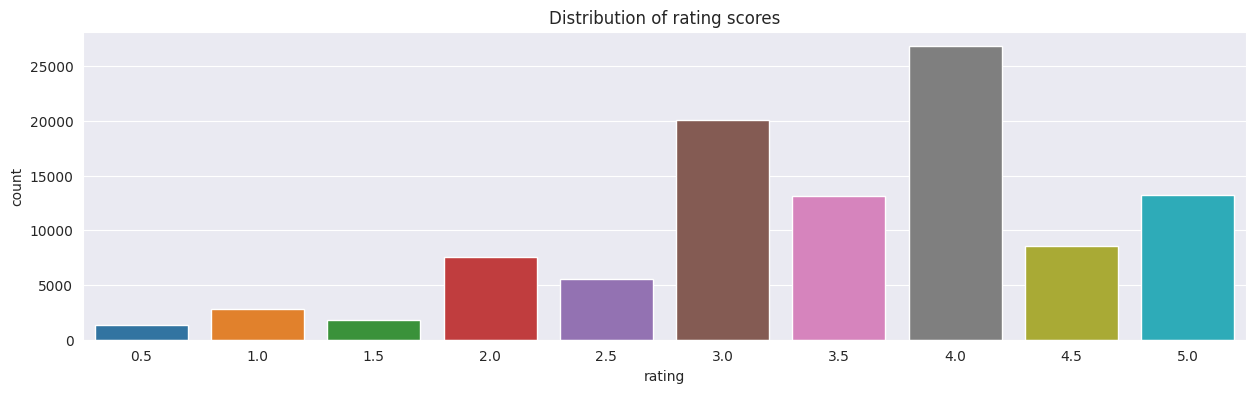

In [ ]:
# to check if there are duplicated ratings
print("duplicated ratings? ({})".format(dfs['ratings'].groupBy("userID", "movieID").count().count() != dfs['ratings'].count()))

rating_ratio = dfs['ratings'].count() / (dfs['ratings'].groupBy("userID").count().count() * dfs['ratings'].groupBy("movieID").count().count())
type(rating_ratio)
print("Only %.2f%% matrix cells have rating score." % (rating_ratio * 100))

rating_scores = dfs['ratings'].groupBy("rating").count().orderBy('rating')

print("\nrating scores info:\n"+"="*40)
rating_scores.show(rating_scores.count())
print("statistical info for rating scores:\n"+"="*40)
print(rating_scores.toPandas()['count'].describe())

print("\nstatistical distribution for the rating scores:\n"+"="*40)
fig = plt.figure(figsize=[15,4])
sns.barplot(x='rating', y='count', data=rating_scores.toPandas())
plt.title("Distribution of rating scores")
fig.show()

#### Rating time distribution

+------+-------+------+---------+-----------+
|userId|movieId|rating|timestamp|rating_date|
+------+-------+------+---------+-----------+
|1     |1      |4.0   |964982703|2000-07-30 |
|1     |3      |4.0   |964981247|2000-07-30 |
|1     |6      |4.0   |964982224|2000-07-30 |
|1     |47     |5.0   |964983815|2000-07-30 |
|1     |50     |5.0   |964982931|2000-07-30 |
|1     |70     |3.0   |964982400|2000-07-30 |
|1     |101    |5.0   |964980868|2000-07-30 |
|1     |110    |4.0   |964982176|2000-07-30 |
|1     |151    |5.0   |964984041|2000-07-30 |
|1     |157    |5.0   |964984100|2000-07-30 |
+------+-------+------+---------+-----------+
only showing top 10 rows

+----------------+----------------+
|min(rating_date)|max(rating_date)|
+----------------+----------------+
|      1996-03-29|      2018-09-24|
+----------------+----------------+

  rating_date  count
0  1996-03-29     58
1  1996-04-12      9
2  1996-04-17     85
3  1996-04-18     53
4  1996-04-23     18


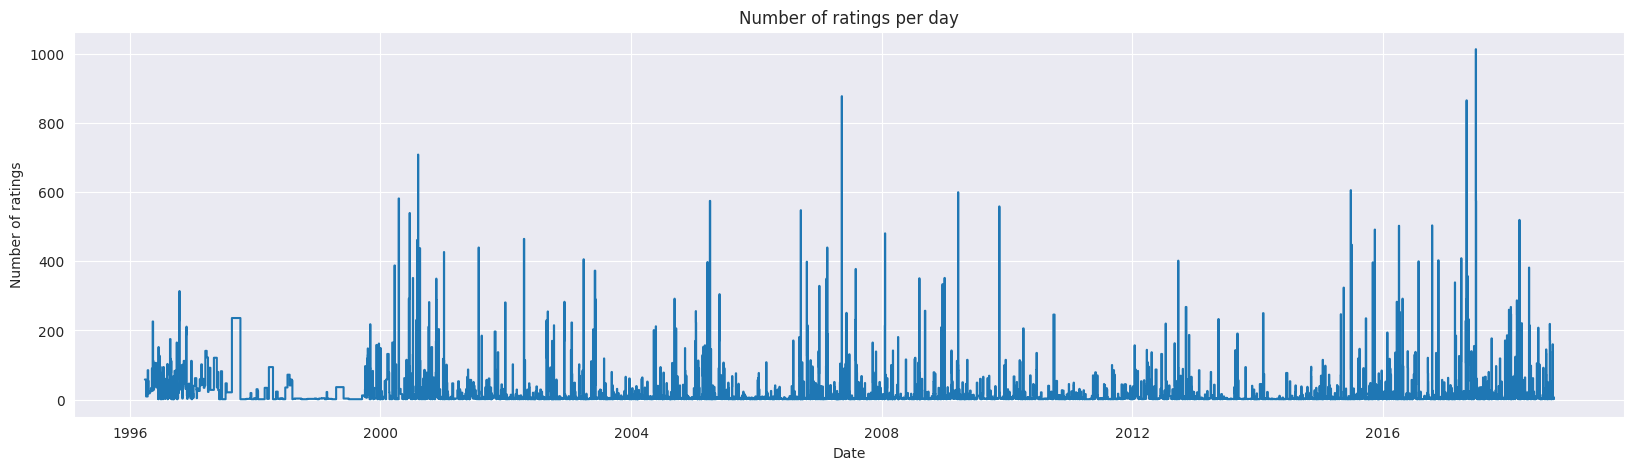

In [ ]:
from pyspark.sql.types import DateType

# transform rating timestamp to date
rating_mat = dfs['ratings'].withColumn('rating_date', F.from_unixtime('timestamp').cast(DateType()))
rating_mat.show(10, False)

# rating time range
rating_mat.select(F.min('rating_date'), F.max('rating_date')).show()

# number of ratings per day
rating_per_day = rating_mat.groupBy('rating_date').count().orderBy('rating_date').toPandas()
print(rating_per_day.head())

# visulize the rating time distribution
fig = plt.figure(figsize=[20, 5])
plt.step(rating_per_day['rating_date'], rating_per_day['count'], where='mid')
plt.xlabel('Date')
plt.ylabel('Number of ratings')
plt.title('Number of ratings per day')
plt.show()

rating_mat = rating_mat.toPandas()

#### Jointplot

<Figure size 2000x2000 with 0 Axes>

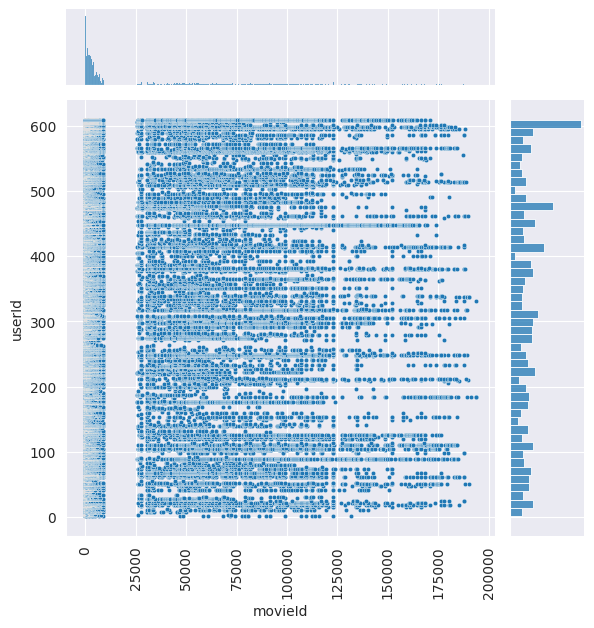

In [ ]:
fig = plt.figure(figsize=[20, 20])
sns.jointplot(x='movieId', y='userId', data=rating_mat, s=10)
plt.xticks(rotation=90)
plt.show()

#### Heatmap

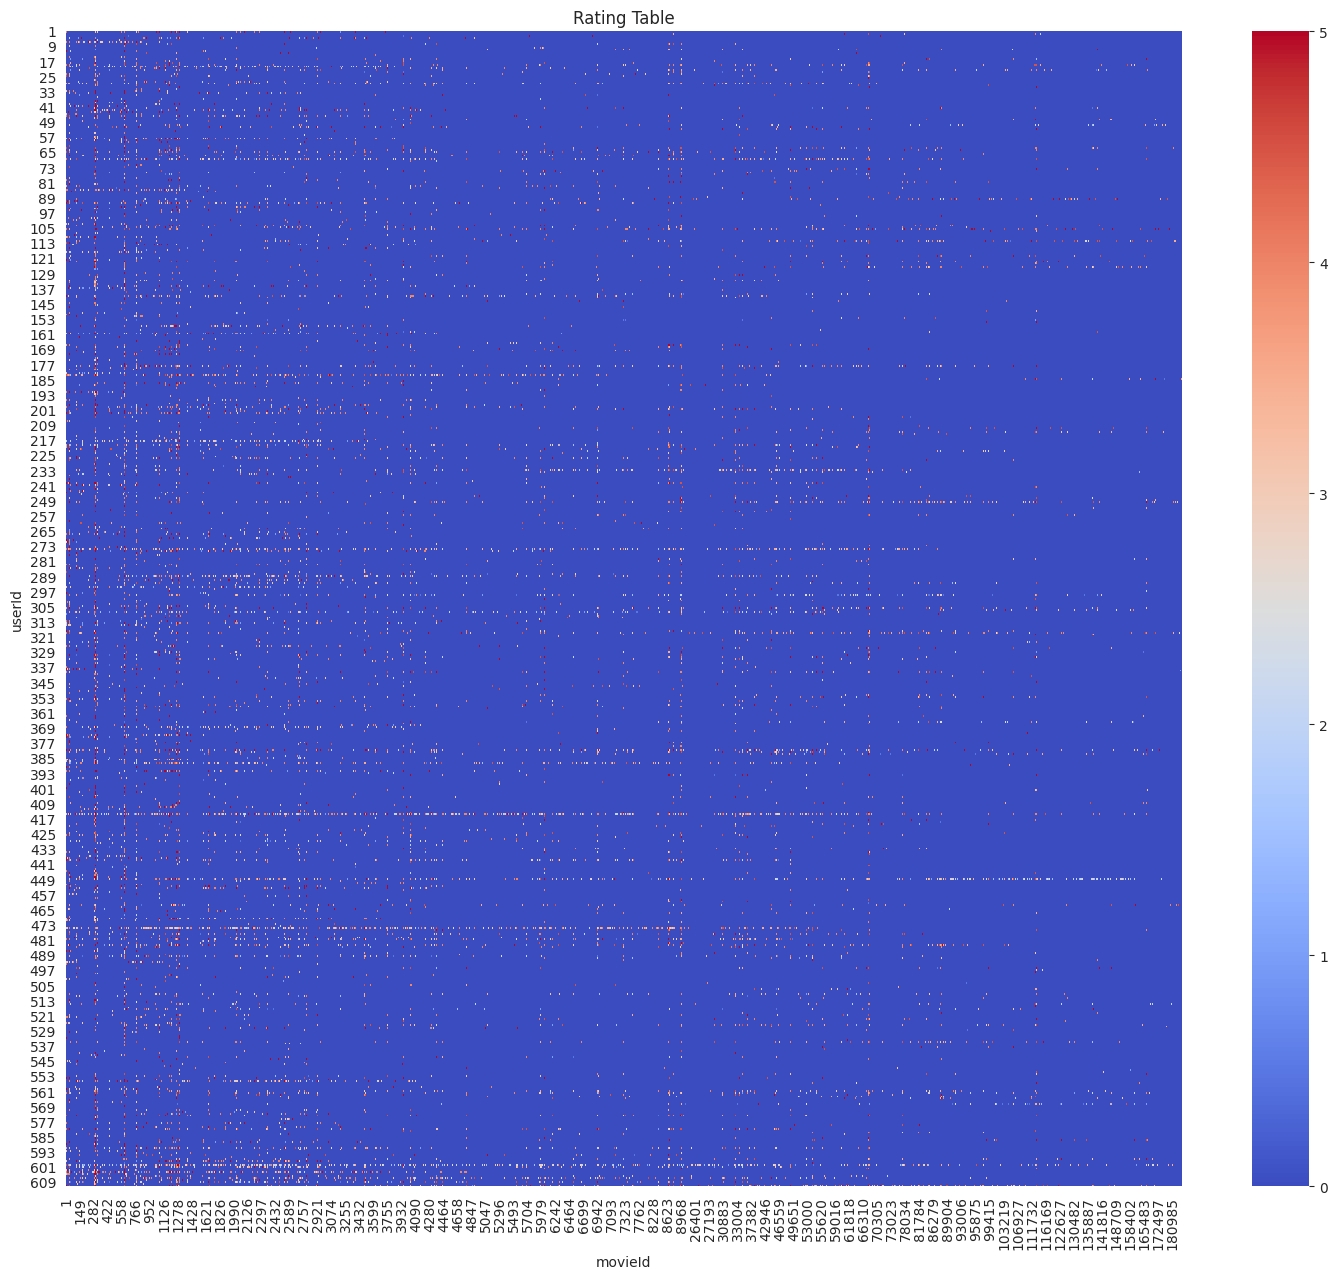

In [ ]:
rating_heatmap = pd.pivot_table(rating_mat, index=['userId'],\
                                columns=['movieId'], values='rating', fill_value=0)
fig = plt.figure(figsize=[18, 15])
ax = sns.heatmap(rating_heatmap, cmap="coolwarm", center=2.5)
ax.set_title("Rating Table")
plt.show()

#### Rating statistical information

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: Number of movieId, dtype: float64


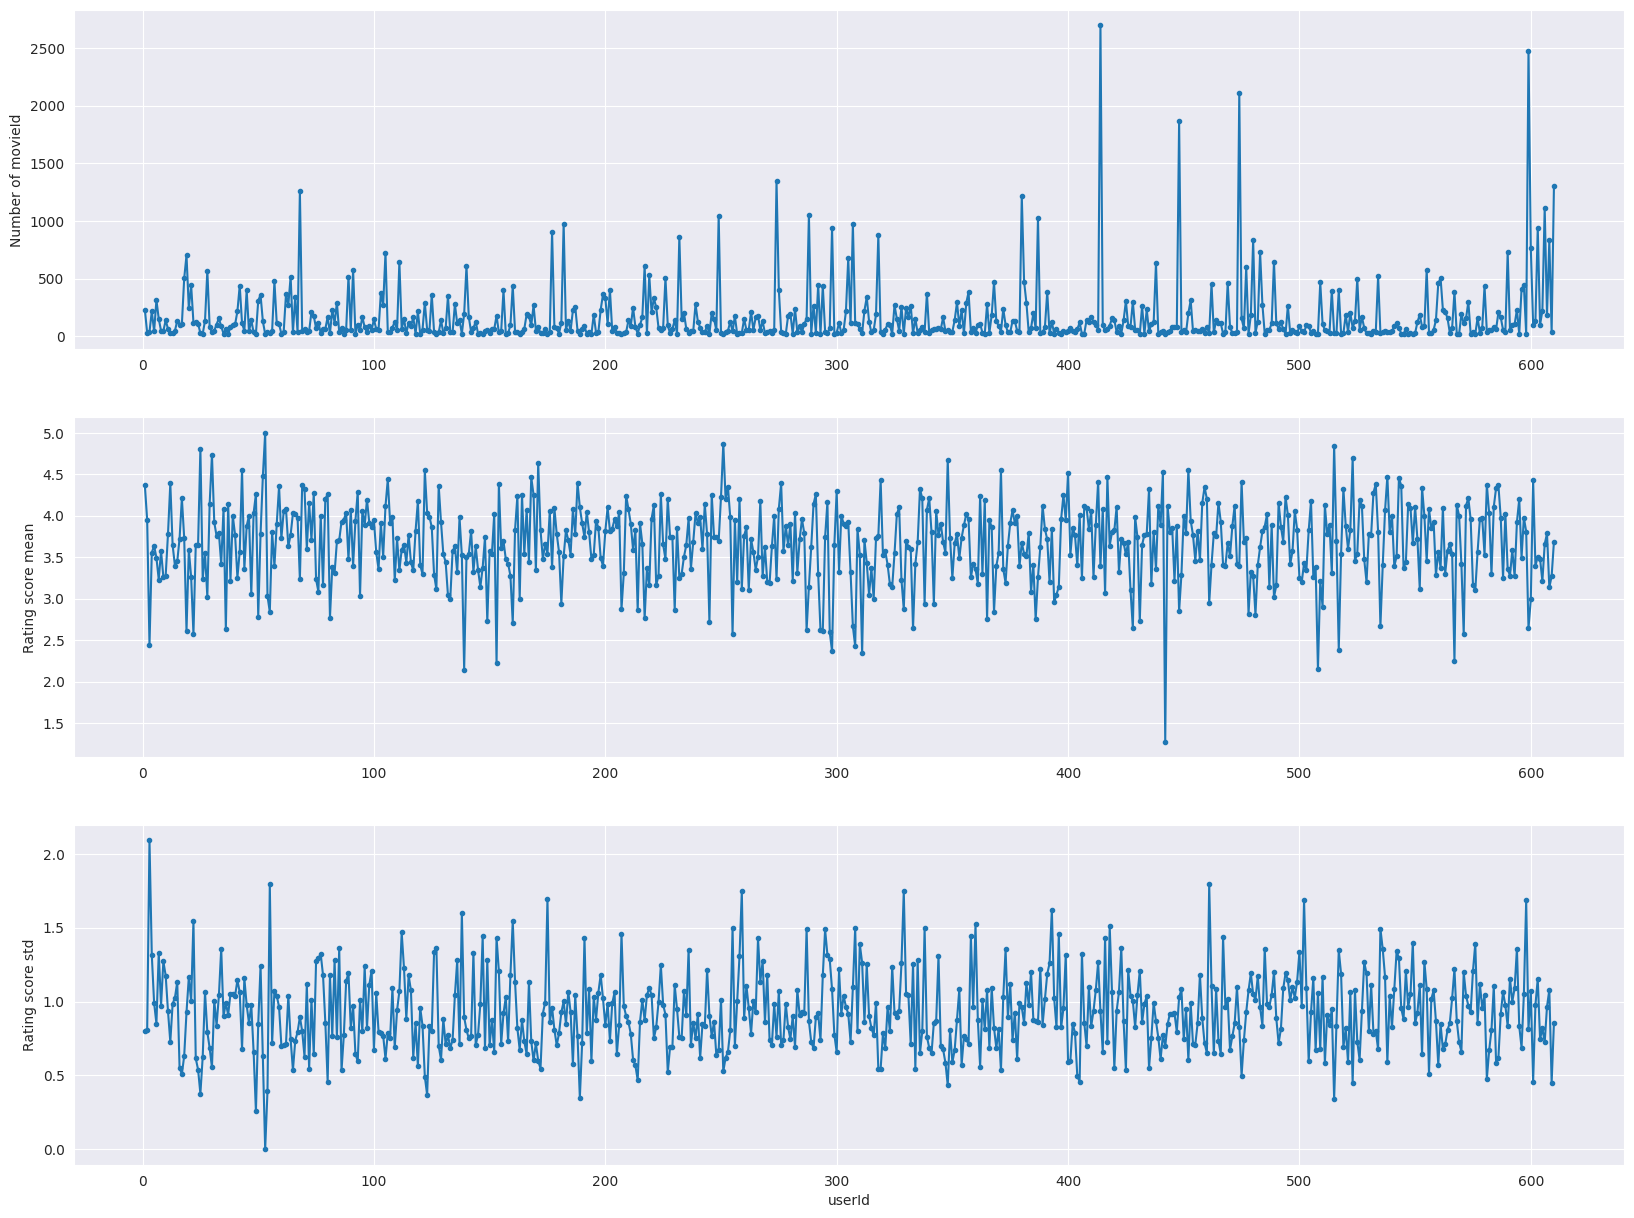

In [ ]:
def ratingColInfo(col1='userId', col2='movieId', rating_mat=rating_mat):
  ratingCol = rating_mat.groupby(col1)['rating'].agg(['size', 'mean', 'std'])
  ratingCol.columns = [f'Number of {col2}', 'Rating score mean', 'Rating score std']
  print(ratingCol.iloc[:, 0].describe())
  fig, axs = plt.subplots(3, 1, figsize=[20, 15])
  for i, c in enumerate(ratingCol.columns):
    axs[i].plot(ratingCol.index, ratingCol[c], '.-')
    axs[i].set_ylabel(c)
  _ = plt.xlabel(col1)
  return ratingCol

rating_userId = ratingColInfo()

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: Number of userId, dtype: float64


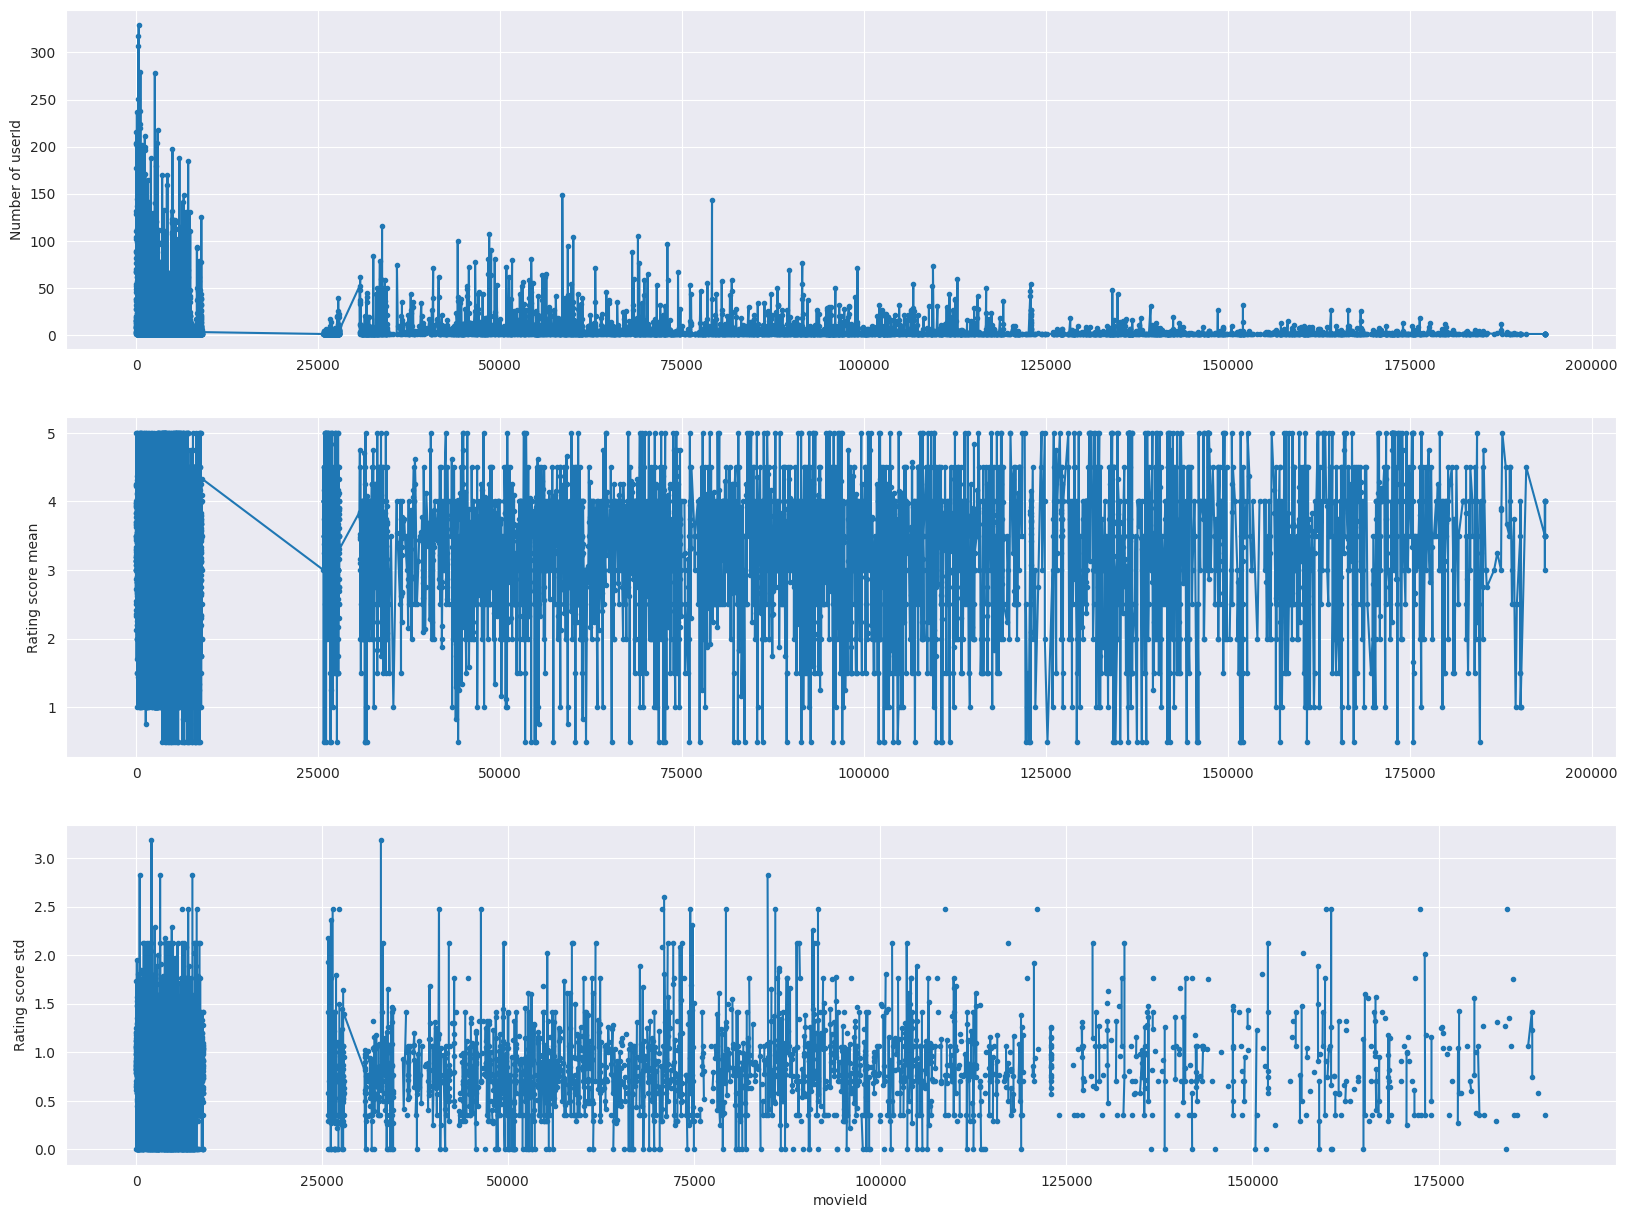

In [ ]:
rating_movieId = ratingColInfo(col2='userId', col1='movieId')

### 1.3.4 Movies Features

# of movies for each category:
+------------------+-----+--------------------+
|          Category|count|              titles|
+------------------+-----+--------------------+
|             Drama| 4361|[Waiting to Exhal...|
|            Comedy| 3756|[Toy Story (1995)...|
|          Thriller| 1894|[Heat (1995), Gol...|
|            Action| 1828|[Heat (1995), Sud...|
|           Romance| 1596|[Grumpier Old Men...|
|         Adventure| 1263|[Toy Story (1995)...|
|             Crime| 1199|[Heat (1995), Cas...|
|            Sci-Fi|  980|[Powder (1995), C...|
|            Horror|  978|[Dracula: Dead an...|
|           Fantasy|  779|[Toy Story (1995)...|
|          Children|  664|[Toy Story (1995)...|
|         Animation|  611|[Toy Story (1995)...|
|           Mystery|  573|[Copycat (1995), ...|
|       Documentary|  440|[Nico Icon (1995)...|
|               War|  382|[Richard III (199...|
|           Musical|  334|[Pocahontas (1995...|
|           Western|  167|[Desperado (1995)...|
|        

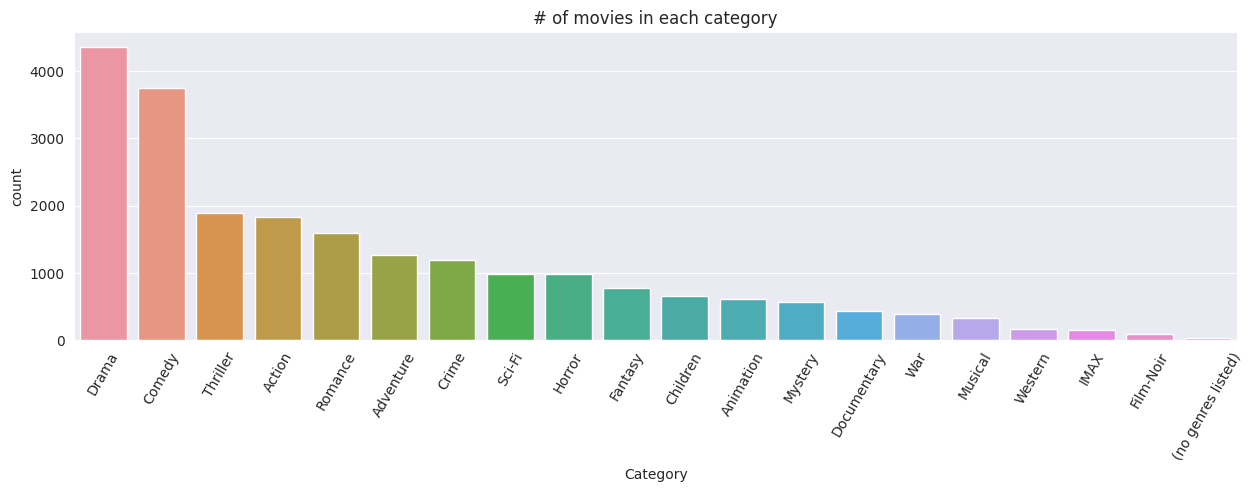

In [ ]:
movie_category = dfs['movies'].select('title', F.explode(F.split('genres', '\|')).alias('Category'))\
    .groupBy("Category")\
    .agg(F.count('title').alias('count'), F.collect_list('title').alias('titles'))\
    .orderBy('count', ascending=False)

print("# of movies for each category:\n"+"="*40)
movie_category.show(movie_category.count())
print("statistical info for movies numbers in each category:\n"+"="*40)
print(movie_category.toPandas()['count'].describe())

print("\n# of movies in each category:\n"+"="*40)
fig = plt.figure(figsize=[15,4])
sns.barplot(x='Category', y='count', data=movie_category.toPandas())
plt.title("# of movies in each category")
plt.xticks(rotation=60)
fig.show()

#### Unrated Movies

In [ ]:
ratedID_set = set(dfs['ratings'].select('movieId').rdd.flatMap(lambda x: x).collect())
movies_unrated = dfs['movies'].filter(~F.col('movieID').isin(ratedID_set))
print(f'There are total {dfs["movies"].count()} movies:\n\t{len(ratedID_set)} rated\n\t{movies_unrated.count()} unrated')
movies_unrated.show(truncate=False)

There are total 9742 movies:
	9724 rated
	18 unrated
+-------+--------------------------------------------+------------------------+
|movieId|title                                       |genres                  |
+-------+--------------------------------------------+------------------------+
|1076   |Innocents, The (1961)                       |Drama|Horror|Thriller   |
|2939   |Niagara (1953)                              |Drama|Thriller          |
|3338   |For All Mankind (1989)                      |Documentary             |
|3456   |Color of Paradise, The (Rang-e khoda) (1999)|Drama                   |
|4194   |I Know Where I'm Going! (1945)              |Drama|Romance|War       |
|5721   |Chosen, The (1981)                          |Drama                   |
|6668   |Road Home, The (Wo de fu qin mu qin) (1999) |Drama|Romance           |
|6849   |Scrooge (1970)                              |Drama|Fantasy|Musical   |
|7020   |Proof (1991)                                |Comedy|Drama|

## 1.4 Data type conversion

In [ ]:
from pyspark.sql.types import IntegerType, FloatType, DateType

sdf_rating = dfs['ratings'].withColumn('rating_date', F.from_unixtime('timestamp').cast(DateType()))\
    .select(F.col('userID').cast(IntegerType()).alias('userID'),
            F.col('movieID').cast(IntegerType()).alias('movieID'),
            F.col('rating').cast(FloatType()).alias('rating'),
            'rating_date', 'timestamp')

sdf_rating.show()

+------+-------+------+-----------+---------+
|userID|movieID|rating|rating_date|timestamp|
+------+-------+------+-----------+---------+
|     1|      1|   4.0| 2000-07-30|964982703|
|     1|      3|   4.0| 2000-07-30|964981247|
|     1|      6|   4.0| 2000-07-30|964982224|
|     1|     47|   5.0| 2000-07-30|964983815|
|     1|     50|   5.0| 2000-07-30|964982931|
|     1|     70|   3.0| 2000-07-30|964982400|
|     1|    101|   5.0| 2000-07-30|964980868|
|     1|    110|   4.0| 2000-07-30|964982176|
|     1|    151|   5.0| 2000-07-30|964984041|
|     1|    157|   5.0| 2000-07-30|964984100|
|     1|    163|   5.0| 2000-07-30|964983650|
|     1|    216|   5.0| 2000-07-30|964981208|
|     1|    223|   3.0| 2000-07-30|964980985|
|     1|    231|   5.0| 2000-07-30|964981179|
|     1|    235|   4.0| 2000-07-30|964980908|
|     1|    260|   5.0| 2000-07-30|964981680|
|     1|    296|   3.0| 2000-07-30|964982967|
|     1|    316|   3.0| 2000-07-30|964982310|
|     1|    333|   5.0| 2000-07-30

# **Part 2: Spark ALS (Alternating Least Squares) model**

## 2.1 Model building and training

### 2.1.1 Packages

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

### 2.1.2 Split training and testing dataset

In [ ]:
# Random split
#(training, testing) = sdf_rating.randomSplit([0.8, 0.2])

# Split along rating time
ts1 = sdf_rating.approxQuantile("timestamp", [0.8], 0)[0]
#print(ts1)
training = sdf_rating.filter(F.col('timestamp') <= ts1)
testing = sdf_rating.filter(F.col('timestamp') > ts1)

print('Percentage of training data: %.2f%%' % (training.count()/(training.count()+testing.count()) * 100))
assert training.count()+testing.count() == sdf_rating.count()

Percentage of training data: 80.00%


### 2.1.3 ALS model instance

In [ ]:
als = ALS(userCol="userID", itemCol="movieID", ratingCol="rating", coldStartStrategy="drop")

### 2.1.4 Tune model using ParamGridBuilder

In [ ]:
paragrid = ParamGridBuilder()\
    .addGrid(als.maxIter, [5, 10, 20])\
    .addGrid(als.rank, [6, 8, 10, 12, 14])\
    .addGrid(als.regParam, [0.01, 0.05, 0.1, 0.5, 1.0])\
    .build()

### 2.1.5 Define evaluator as RMSE

In [ ]:
RMSE_eval = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

### 2.1.6 Build Cross Validation

In [ ]:
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paragrid,
                          evaluator=RMSE_eval,
                          numFolds=3,
                          collectSubModels=True,
                          seed=42)

### 2.1.7 Fit ALS model to training data

In [ ]:
cv_models = crossval.fit(training)

## 2.2 Model evaluation

### 2.2.1 Training 'history'

        rmse  maxIter  rank  regParam
0   1.062280        5     6      0.01
1   0.961597        5     6      0.05
2   0.910582        5     6      0.10
3   1.012808        5     6      0.50
4   1.324943        5     6      1.00
..       ...      ...   ...       ...
70  1.308122       20    14      0.01
71  0.991798       20    14      0.05
72  0.912160       20    14      0.10
73  1.011528       20    14      0.50
74  1.325302       20    14      1.00

[75 rows x 4 columns]


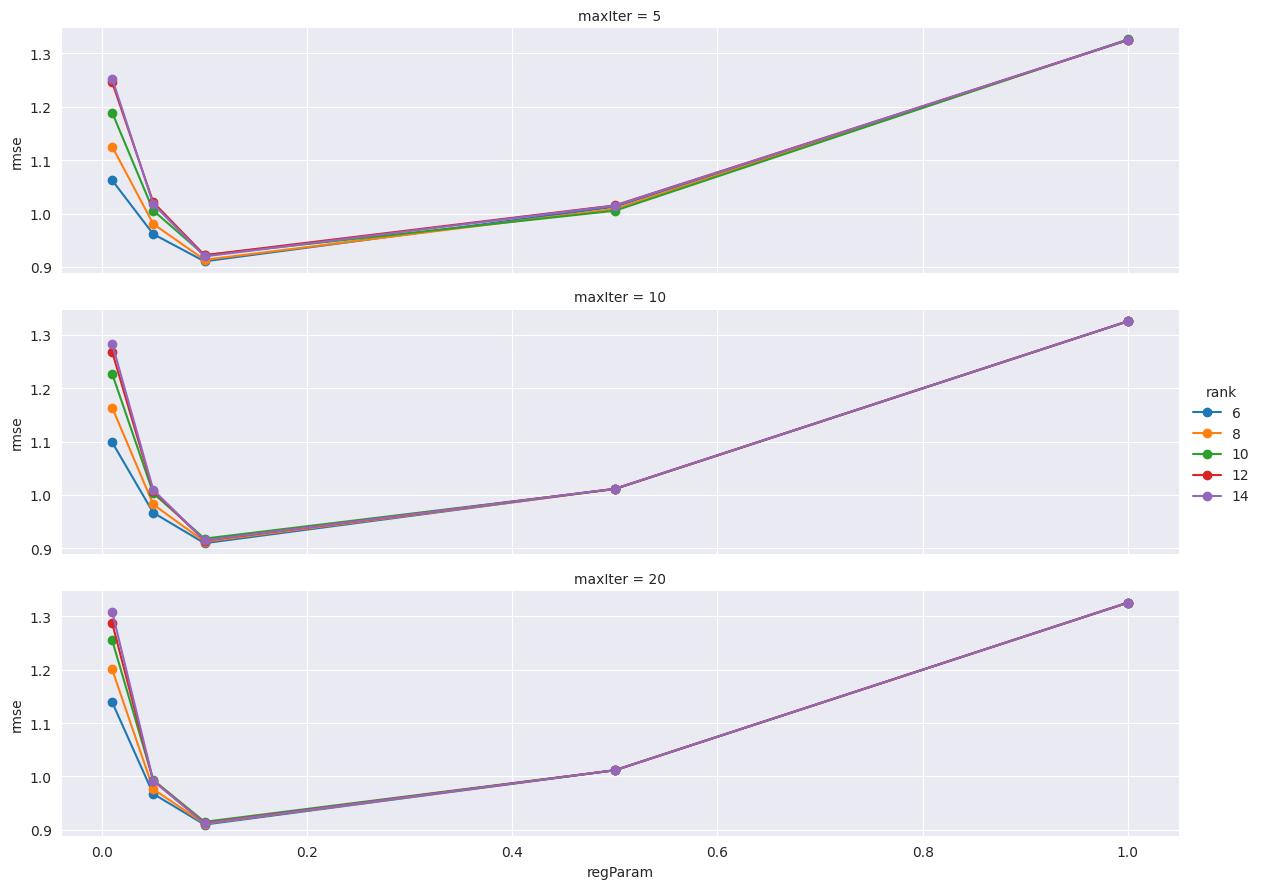

In [ ]:
params = [{p.name: v for p, v in m.items()} for m in cv_models.getEstimatorParamMaps()]
#print(params)

fitting_params = pd.DataFrame.from_dict([
    {cv_models.getEvaluator().getMetricName(): metric, **ps}
    for ps, metric in zip(params, cv_models.avgMetrics)])
print(fitting_params)

g = sns.FacetGrid(fitting_params, row="maxIter", hue='rank', height=3, aspect=4)
g = g.map(plt.plot, 'regParam', 'rmse', marker='o').add_legend()

### 2.2.2 Best model

In [ ]:
best_model = cv_models.bestModel
params_best = {"rank": best_model.rank,
               "maxIter": best_model._java_obj.parent().getMaxIter(),
               "regParam": best_model._java_obj.parent().getRegParam()}

print(f'Params of the best model is:\n{params_best}')

Params of the best model is:
{'rank': 6, 'maxIter': 10, 'regParam': 0.1}


In [ ]:
#params_best = {'rank': 6, 'maxIter': 10, 'regParam': 0.1}

### 2.2.3 Model performance over testing

In [ ]:
test_pred = best_model.transform(testing)
print(f"RMSE_testing = {RMSE_eval.evaluate(test_pred)}")
test_pred.show()

RMSE_testing = 0.9364073619581043
+------+-------+------+-----------+----------+----------+
|userID|movieID|rating|rating_date| timestamp|prediction|
+------+-------+------+-----------+----------+----------+
|   233|   1580|   3.0| 2018-06-18|1529334057| 3.2439833|
|   495|   1580|   3.5| 2016-03-22|1458635792|  4.035255|
|   495|   1645|   5.0| 2016-03-22|1458635970| 3.7292573|
|   298|   4900|   2.5| 2016-07-02|1467489493| 2.3142097|
|    18|  32460|   3.5| 2017-04-21|1492805550| 4.3567295|
|   414|  44022|   2.5| 2017-03-15|1489548300| 3.1665792|
|   414|  96488|   4.5| 2018-04-01|1522624379|  4.361037|
|    18|  96488|   4.0| 2018-01-09|1515532582|  4.120465|
|   233|    858|   4.0| 2018-04-26|1524781360|  3.951443|
|    15|    858|   4.0| 2017-11-13|1510571941| 4.8408065|
|   601|   1721|   4.0| 2018-03-18|1521398191|  3.800793|
|   233|   1721|   3.5| 2018-06-18|1529334058| 3.1122904|
|   495|   1721|   5.0| 2016-03-22|1458635859| 3.5275455|
|   601|  48780|   4.5| 2018-03-19|152

### 2.2.4 Re-fitting model with best super-parameters and the whole dataset

In [ ]:
als = ALS(userCol='userID', itemCol='movieID', ratingCol='rating',
          coldStartStrategy='drop', **params_best)
best_model = als.fit(sdf_rating)

preds = best_model.transform(sdf_rating)
print(f'RMSE = {RMSE_eval.evaluate(preds)}')

preds = preds.withColumn('round_pred', F.round(F.col('prediction') * 2)/2)
preds.show()

RMSE = 0.6419816212507591
+------+-------+------+-----------+----------+----------+----------+
|userID|movieID|rating|rating_date| timestamp|prediction|round_pred|
+------+-------+------+-----------+----------+----------+----------+
|   191|    148|   5.0| 1996-04-17| 829760897| 4.9026566|       5.0|
|   133|    471|   4.0| 1996-09-23| 843491793| 3.1249695|       3.0|
|   597|    471|   2.0| 1999-11-02| 941558175|  4.049033|       4.0|
|   385|    471|   4.0| 1996-12-16| 850766697| 3.1493487|       3.0|
|   436|    471|   3.0| 1996-05-31| 833530187| 3.6589158|       3.5|
|   602|    471|   4.0| 1996-08-24| 840876085|  3.453949|       3.5|
|    91|    471|   1.0| 2005-04-05|1112713817| 2.4799662|       2.5|
|   409|    471|   3.0| 2000-09-02| 967912821| 3.6680882|       3.5|
|   372|    471|   3.0| 1997-09-16| 874415126| 3.1618757|       3.0|
|   599|    471|   2.5| 2017-06-26|1498518822| 2.7643316|       3.0|
|   603|    471|   4.0| 2000-03-31| 954482443| 3.4804773|       3.5|
|   182|

#### Performance over each movie

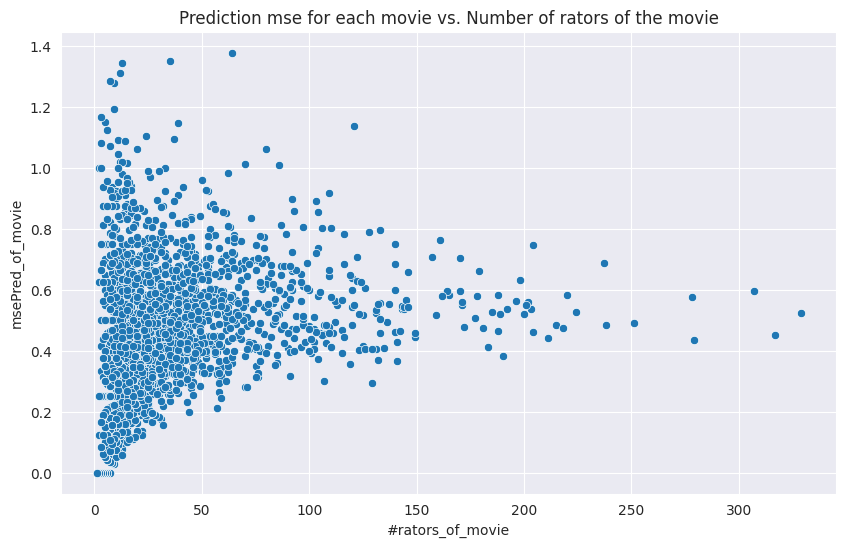

In [ ]:
msePred_movie = preds.groupBy('movieID')\
    .agg(F.mean((F.col('rating') - F.col('round_pred'))**2).alias('msePred_of_movie'),
         F.count('rating').alias('#rators_of_movie'))

fig = plt.figure(figsize=[10,6])
sns.scatterplot(x='#rators_of_movie', y='msePred_of_movie', data=msePred_movie.toPandas())
plt.title("Prediction mse for each movie vs. Number of rators of the movie")
fig.show()

#### Performance over each user

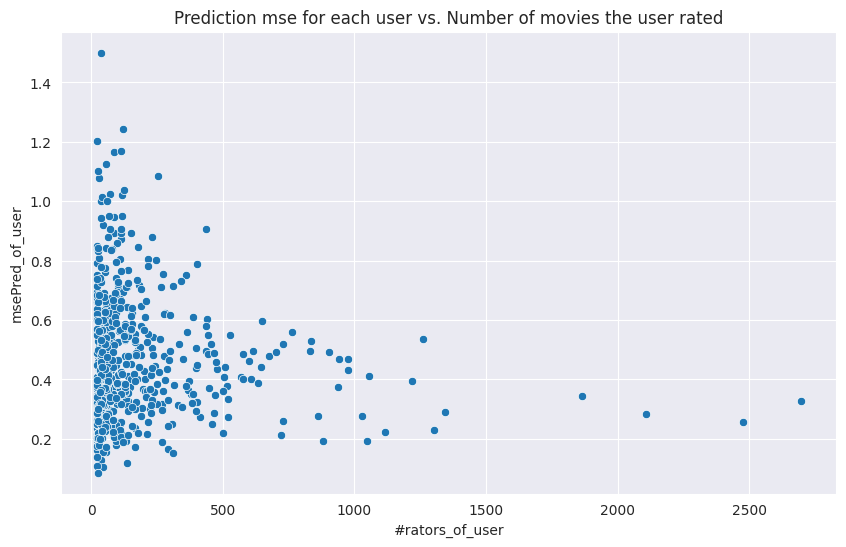

In [ ]:
msePred_user = preds.groupBy('userID')\
    .agg(F.mean((F.col('rating') - F.col('round_pred'))**2).alias('msePred_of_user'),
         F.count('rating').alias('#rators_of_user'))

fig = plt.figure(figsize=[10,6])
sns.scatterplot(x='#rators_of_user', y='msePred_of_user', data=msePred_user.toPandas())
plt.title("Prediction mse for each user vs. Number of movies the user rated")
fig.show()

# **Part 3: Personalized Movie Recommendation**

## 3.1 Movie properties table

In [ ]:
dfs['movies'].show(10, truncate=False)
dfs['links'].show(10, truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
|6      |Heat (1995)                       |Action|Crime|Thriller                      |
|7      |Sabrina (1995)                    |Comedy|Romance                             |
|8      |Tom and Huck (1995)               |Adventure|Children                         |
|9      |Sudden Death

### 3.1.1 Split title into title and release_year

In [ ]:
import re
from pyspark.sql.types import StructType, StructField, StringType, ArrayType

def title_split(title):
  res = re.search('\(\d{4}\)', title)
  if res:
    return title[:res.start()-1], int(res.group()[1:5])
  else:
    print(f'The movie title "{title}" not in a good format')
    return title, 1000

udf_title_split = F.udf(title_split, StructType([StructField('title', StringType(), True),
                                                 StructField('release_year', IntegerType(), True)]))
#title_split('abc ( 1995)')

### 3.1.2 Transform genres into list

In [ ]:
udf_genres_list = F.udf(lambda x: x.lower().split('|'), ArrayType(StringType()))

### 3.1.3 Movie_tab

In [ ]:
movie_tab = dfs['movies'].select('movieId', udf_title_split('title').title.alias('title'),\
                                 udf_title_split('title').release_year.alias('release_year'),\
                                 'genres',\
                                 udf_genres_list('genres').alias('genresList'))
                                 #'genres')
movie_tab.show(10, truncate=False)

+-------+---------------------------+------------+-------------------------------------------+-------------------------------------------------+
|movieId|title                      |release_year|genres                                     |genresList                                       |
+-------+---------------------------+------------+-------------------------------------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |Adventure|Animation|Children|Comedy|Fantasy|[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |Adventure|Children|Fantasy                 |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |Comedy|Romance                             |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |Comedy|Drama|Romance                       |[comedy, drama, romance]            

### 3.1.4 Merge TMDBid

In [ ]:
movie_tab = movie_tab.join(dfs['links'].drop('imdbId'), on=['movieId'], how='left')
movie_tab.show(10, truncate=False)

+-------+---------------------------+------------+-------------------------------------------+-------------------------------------------------+------+
|movieId|title                      |release_year|genres                                     |genresList                                       |tmdbId|
+-------+---------------------------+------------+-------------------------------------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |Adventure|Animation|Children|Comedy|Fantasy|[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |Adventure|Children|Fantasy                 |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |Comedy|Romance                             |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |Comedy|Drama|Romance                  

### 3.1.5 Display movie poster using TMDB API

In [ ]:
!pip install tmdbsimple
import tmdbsimple as tmdb
from IPython.display import Image, display, HTML

#tmdb.API_KEY = 'YOU_KEY'
tmdb.API_KEY = 'acc4'

def movie_poster(df_recom):
  my_html = "<table border=0><tr>"
  for i in range(df_recom.shape[0]):
    img_alt = df_recom.iloc[i]['title']
    try:
      image_path = 'not-a-real.jpg'
      poster_path = tmdb.Movies(df_recom.iloc[i]['tmdbId']).info()['poster_path']
      image_path = f"https://image.tmdb.org/t/p/w500{poster_path}"
      my_html += f'<td><img src={image_path} width=200></img></td>'
    except Exception:
      my_html += f'<td><img src={image_path} alt="{img_alt}" width=200></img></td>'
      #print(f"No movie posters for {img_alt}")
    if i % 5 == 4:
      my_html += '</tr><tr>'
  my_html += '</tr></table>'
  #print(my_html)
  display(HTML(my_html))

### 3.1.6 Highest rated movies

In [ ]:
recom_popu = sdf_rating.groupBy('movieId').agg({'rating': 'mean'})\
             .join(movie_tab, on=['movieId'], how='left')\
             .orderBy(['avg(rating)', 'release_year'], ascending=False)

print(f'{"="*10} Here are our most popular movies: {"="*10}')
recom_popu.show(5, False)
movie_poster(recom_popu.limit(5).toPandas())

========== Here are our most popular movies: ==========
+-------+-----------+-------------------------+------------+---------------------+-------------------------+------+
|movieId|avg(rating)|title                    |release_year|genres               |genresList               |tmdbId|
+-------+-----------+-------------------------+------------+---------------------+-------------------------+------+
|187717 |5.0        |Won't You Be My Neighbor?|2018        |Documentary          |[documentary]            |490003|
|179133 |5.0        |Loving Vincent           |2017        |Animation|Crime|Drama|[animation, crime, drama]|339877|
|172705 |5.0        |Tickling Giants          |2017        |Documentary          |[documentary]            |390319|
|167064 |5.0        |I Am Not Your Negro      |2017        |Documentary          |[documentary]            |411019|
|179135 |5.0        |Blue Planet II           |2017        |Documentary          |[documentary]            |463612|
+-------+-------

,,,,


## 3.2 Recommend movies to specific users

In [ ]:
from pyspark.ml.linalg import Vectors, DenseVector

def recom_user(userId, n_recom=10, genres=None):
  user_fact = best_model.userFactors.filter(F.col('id') == userId)
  if user_fact.count() != 1:
    print(f'{"="*10} Welcome, new user-{userId}! Here are our most popular movies: {"="*10}')
    recom_tab = recom_popu
    if genres:
      recom_tab.filter(F.col('genres').contains(genres))
    recom_tab.show(n_recom, truncate=False)
    movie_poster(recom_tab.limit(n_recom).toPandas())
  else:
    user_fact = Vectors.dense(user_fact.take(1)[0]['features'])
    dot_prod_udf = F.udf(lambda v: float(Vectors.dense(v).dot(user_fact)), FloatType())
    pred_tab = best_model.itemFactors.withColumn('predict', dot_prod_udf(F.col('features')))
    pred_tab = pred_tab.select(F.col('id').alias('movieId'), 'predict')\
               .join(movie_tab, on=['movieId'], how='left')

    history_tab = sdf_rating.filter(F.col('userId') == userId)\
                  .select('movieId', 'rating', 'rating_date')\
                  .join(pred_tab, on=['movieId'], how='left')\
                  .orderBy(['rating', 'rating_date'], ascending=False)
    print(f'{"="*10} Welcome back, user-{userId}! Here are the movies you had highly rated recently: {"="*10}')
    history_tab.show(n_recom, truncate=False)
    movie_poster(history_tab.limit(n_recom).toPandas())

    rated_m = set(history_tab.select('movieId').rdd.flatMap(lambda x: x).collect())
    recom_tab = pred_tab.filter(~F.col('movieId').isin(rated_m))
    if genres:
      recom_tab = recom_tab.filter(F.col('genres').contains(genres))
    recom_tab = recom_tab.orderBy('predict', ascending=False)
    print(f'\n{"="*10} Here are the movies I recommend to you: {"="*10}')
    recom_tab.show(n_recom, truncate=False)
    movie_poster(recom_tab.limit(n_recom).toPandas())

### 3.2.1 Recommend movie to userId "-575"

In [ ]:
recom_user(-575)

========== Welcome, new user--575! Here are our most popular movies: ==========
+-------+-----------+------------------------------+------------+-----------------------------------+----------------------------------------+------+
|movieId|avg(rating)|title                         |release_year|genres                             |genresList                              |tmdbId|
+-------+-----------+------------------------------+------------+-----------------------------------+----------------------------------------+------+
|187717 |5.0        |Won't You Be My Neighbor?     |2018        |Documentary                        |[documentary]                           |490003|
|179135 |5.0        |Blue Planet II                |2017        |Documentary                        |[documentary]                           |463612|
|179133 |5.0        |Loving Vincent                |2017        |Animation|Crime|Drama              |[animation, crime, drama]               |339877|
|172705 |5.0        

,,,,
,,,,


### 3.2.2 Recommend movie to userId "575"

In [ ]:
recom_user(575)

========== Welcome back, user-575! Here are the movies you had highly rated recently: ==========
+-------+------+-----------+---------+-----------------------------------------------+------------+---------------------------+--------------------------------+------+
|movieId|rating|rating_date|predict  |title                                          |release_year|genres                     |genresList                      |tmdbId|
+-------+------+-----------+---------+-----------------------------------------------+------------+---------------------------+--------------------------------+------+
|2622   |5.0   |1999-05-12 |3.9053888|William Shakespeare's A Midsummer Night's Dream|1999        |Comedy|Fantasy             |[comedy, fantasy]               |10210 |
|1259   |5.0   |1999-05-12 |4.2598205|Stand by Me                                    |1986        |Adventure|Drama            |[adventure, drama]              |235   |
|296    |5.0   |1999-05-12 |4.845778 |Pulp Fiction             

,,,,
,,,,



========== Here are the movies I recommend to you: ==========
+-------+---------+---------------------------------------------+------------+--------------------+------------------------+------+
|movieId|predict  |title                                        |release_year|genres              |genresList              |tmdbId|
+-------+---------+---------------------------------------------+------------+--------------------+------------------------+------+
|84847  |6.1108603|Emma                                         |2009        |Comedy|Drama|Romance|[comedy, drama, romance]|183894|
|306    |5.4753156|Three Colors: Red (Trois couleurs: Rouge)    |1994        |Drama               |[drama]                 |110   |
|59018  |5.3313384|Visitor, The                                 |2007        |Drama|Romance       |[drama, romance]        |12473 |
|60943  |5.3313384|Frozen River                                 |2008        |Drama               |[drama]                 |10183 |
|1194   |5.24

,,,,
,,,,


### 3.2.3 Recommend movie to userId "232"

In [ ]:
recom_user(232, genres='Sci-Fi')

========== Welcome back, user-232! Here are the movies you had highly rated recently: ==========
+-------+------+-----------+---------+--------------------+------------+------------------------------------------------+-------------------------------------------------------+------+
|movieId|rating|rating_date|predict  |title               |release_year|genres                                          |genresList                                             |tmdbId|
+-------+------+-----------+---------+--------------------+------------+------------------------------------------------+-------------------------------------------------------+------+
|81591  |5.0   |2011-01-07 |3.4627671|Black Swan          |2010        |Drama|Thriller                                  |[drama, thriller]                                      |44214 |
|78499  |5.0   |2010-08-30 |3.84881  |Toy Story 3         |2010        |Adventure|Animation|Children|Comedy|Fantasy|IMAX|[adventure, animation, children, comedy, f

,,,,
,,,,



========== Here are the movies I recommend to you: ==========
+-------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------------------------------------------+------------------------------------------------+------+
|movieId|predict  |title                                                                                                                                                  |release_year|genres                                    |genresList                                      |tmdbId|
+-------+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------------------------------------------+------------------------------------------------+------+
|104780 |4.5171614|Mystery of the Third Planet, The (Tayna tretey planety)           

,,,,
,,,,


## 3.3 Find the similar moives for input moive

In [ ]:
def recom_movie(movieId, n_recom=10, genres=None):
  curr_movie = movie_tab.filter(F.col('movieId') == movieId)
  if curr_movie.count() != 1:
    print(f'Sorry, the movie you input is not in our system.\nPlease input correct movieId next time.')
    return
  else:
    print(f'{"="*10} Welcome, here is the movie you input:')
    curr_movie.show(truncate=False)
    movie_poster(curr_movie.toPandas())

  movie_fact = best_model.itemFactors.filter(F.col('id') == movieId)
  if movie_fact.count() != 1:
    print(f'{"="*10} The movie-{movieId} you input is a movie we havn"t receive rating yet! {"="*10}')
    print(f'{" "*10} Here I recommend you our most popular movies: {" "*10}')
    recom_tab = recom_popu
    if genres:
      recom_tab.filter(F.col('genres').contains(genres))
    recom_tab.show(n_recom, truncate=False)
    movie_poster(recom_tab.limit(n_recom).toPandas())
  else:
    np_m = np.array(movie_fact.select('features').collect()).reshape(-1, 1)
    np_userF = np.squeeze(np.array(best_model.userFactors.select('features').collect()))
    pred_m = np.dot(np_userF, np_m).reshape(1, -1)
    pred_m = pred_m / np.linalg.norm(pred_m)
    #print(pred_m.shape)

    def cosSim(x):
      np_x = np.array(x).reshape(-1, 1)
      pred_x = np.dot(np_userF, np_x)
      return float(np.dot(pred_m, pred_x) / np.linalg.norm(pred_x))
    udf_cosSim = F.udf(cosSim, FloatType())

    sim_tab = best_model.itemFactors.select(F.col('id').alias('movieId'),\
                                            udf_cosSim(F.col('features')).alias('cosSim'))\
              .join(movie_tab, on=['movieId'], how='left')
    if genres:
      sim_tab = sim_tab.filter(F.col('genres').contains(genres))
    sim_tab = sim_tab.orderBy('cosSim', ascending=False)
    print(f'\n{"="*10} Here are the movies which are most similar to the one you input: {"="*10}')
    sim_tab.show(n_recom, truncate=False)
    movie_poster(sim_tab.limit(n_recom).toPandas())

### 3.3.1 Similar movies for movieId "463"

In [ ]:
recom_movie(463)

Sorry, the movie you input is not in our system.
Please input correct movieId next time.


### 3.3.2 Similar movies for movieId "471"

In [ ]:
recom_movie(471)

========== Welcome, here is the movie you input:
+-------+--------------------+------------+------+----------+------+
|movieId|title               |release_year|genres|genresList|tmdbId|
+-------+--------------------+------------+------+----------+------+
|471    |Hudsucker Proxy, The|1994        |Comedy|[comedy]  |11934 |
+-------+--------------------+------------+------+----------+------+



""



========== Here are the movies which are most similar to the one you input: ==========
+-------+----------+-----------------------------------------------+------------+------------------------------+-----------------------------------+------+
|movieId|cosSim    |title                                          |release_year|genres                        |genresList                         |tmdbId|
+-------+----------+-----------------------------------------------+------------+------------------------------+-----------------------------------+------+
|471    |1.0       |Hudsucker Proxy, The                           |1994        |Comedy                        |[comedy]                           |11934 |
|3097   |0.99939054|Shop Around the Corner, The                    |1940        |Comedy|Drama|Romance          |[comedy, drama, romance]           |20334 |
|2819   |0.9984633 |Three Days of the Condor (3 Days of the Condor)|1975        |Drama|Mystery|Romance|Thriller|[drama, mystery, rom

,,,,
,,,,


### 3.3.3 Similar movies for movieId "2628"

In [ ]:
recom_movie(2628, genres='Sci-Fi')

========== Welcome, here is the movie you input:
+-------+-----------------------------------------+------------+-----------------------+---------------------------+------+
|movieId|title                                    |release_year|genres                 |genresList                 |tmdbId|
+-------+-----------------------------------------+------------+-----------------------+---------------------------+------+
|2628   |Star Wars: Episode I - The Phantom Menace|1999        |Action|Adventure|Sci-Fi|[action, adventure, sci-fi]|1893  |
+-------+-----------------------------------------+------------+-----------------------+---------------------------+------+



""



========== Here are the movies which are most similar to the one you input: ==========
+-------+----------+------------------------------------------------------------------+------------+---------------------------------+--------------------------------------+------+
|movieId|cosSim    |title                                                             |release_year|genres                           |genresList                            |tmdbId|
+-------+----------+------------------------------------------------------------------+------------+---------------------------------+--------------------------------------+------+
|2628   |1.0       |Star Wars: Episode I - The Phantom Menace                         |1999        |Action|Adventure|Sci-Fi          |[action, adventure, sci-fi]           |1893  |
|34150  |0.9990684 |Fantastic Four                                                    |2005        |Action|Adventure|Sci-Fi          |[action, adventure, sci-fi]           |9738  |
|2549  

,,,,
,,,,


### 3.3.4 Similar movies for movieId "4194"

In [ ]:
recom_movie(4194, genres='Sci-Fi')

========== Welcome, here is the movie you input:
+-------+-----------------------+------------+-----------------+---------------------+------+
|movieId|title                  |release_year|genres           |genresList           |tmdbId|
+-------+-----------------------+------------+-----------------+---------------------+------+
|4194   |I Know Where I'm Going!|1945        |Drama|Romance|War|[drama, romance, war]|56137 |
+-------+-----------------------+------------+-----------------+---------------------+------+



""


========== The movie-4194 you input is a movie we havn"t receive rating yet! ==========
           Here I recommend you our most popular movies:           
+-------+-----------+------------------------------+------------+-----------------------------------+----------------------------------------+------+
|movieId|avg(rating)|title                         |release_year|genres                             |genresList                              |tmdbId|
+-------+-----------+------------------------------+------------+-----------------------------------+----------------------------------------+------+
|187717 |5.0        |Won't You Be My Neighbor?     |2018        |Documentary                        |[documentary]                           |490003|
|179135 |5.0        |Blue Planet II                |2017        |Documentary                        |[documentary]                           |463612|
|179133 |5.0        |Loving Vincent                |2017        |Animation|Crime|Drama        

,,,,
,,,,
